In [53]:
import pandas as pd
import geopandas as gpd
import os
import df2img
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [ ]:
file_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\community\BldgPermits_ADUsJADUs.xls"
adu = pd.read_excel(file_path, header=1, dtype={'APN': str})
adu

In [ ]:
# Filter the DataFrame for 'Status' being either 'Issued' or 'In Review'
filtered_adus = adu[adu['Status'].isin(['Issued', 'In Review'])]
filtered_adus

In [ ]:
filtered_adus['Date Submitted'] = pd.to_datetime(adu['Date Submitted'])
filtered_adus['Date Issued'] = pd.to_datetime(adu['Date Issued']) 


In [49]:
# Remove rows where 'Date Issued' or 'Date Submitted' are missing
adu_cleaned = filtered_adus.dropna(subset=['Date Submitted', 'Date Issued'])



In [ ]:
# Create month and year columns for grouping
adu_cleaned['Submitted Month'] = adu_cleaned['Date Submitted'].dt.to_period('M')
adu_cleaned['Issued Month'] = adu_cleaned['Date Issued'].dt.to_period('M')

# Count submissions and issuances by month
monthly_submissions = adu_cleaned['Submitted Month'].value_counts().sort_index()
monthly_issuances = adu_cleaned['Issued Month'].value_counts().sort_index()


In [ ]:
# Create a complete range of months from min to max to fill gaps
all_months = pd.period_range(start=min(monthly_submissions.index.min(), monthly_issuances.index.min()),
                             end=max(monthly_submissions.index.max(), monthly_issuances.index.max()), freq='M')

# Reindex to include all months, filling missing ones with 0
monthly_submissions = monthly_submissions.reindex(all_months, fill_value=0)
monthly_issuances = monthly_issuances.reindex(all_months, fill_value=0)



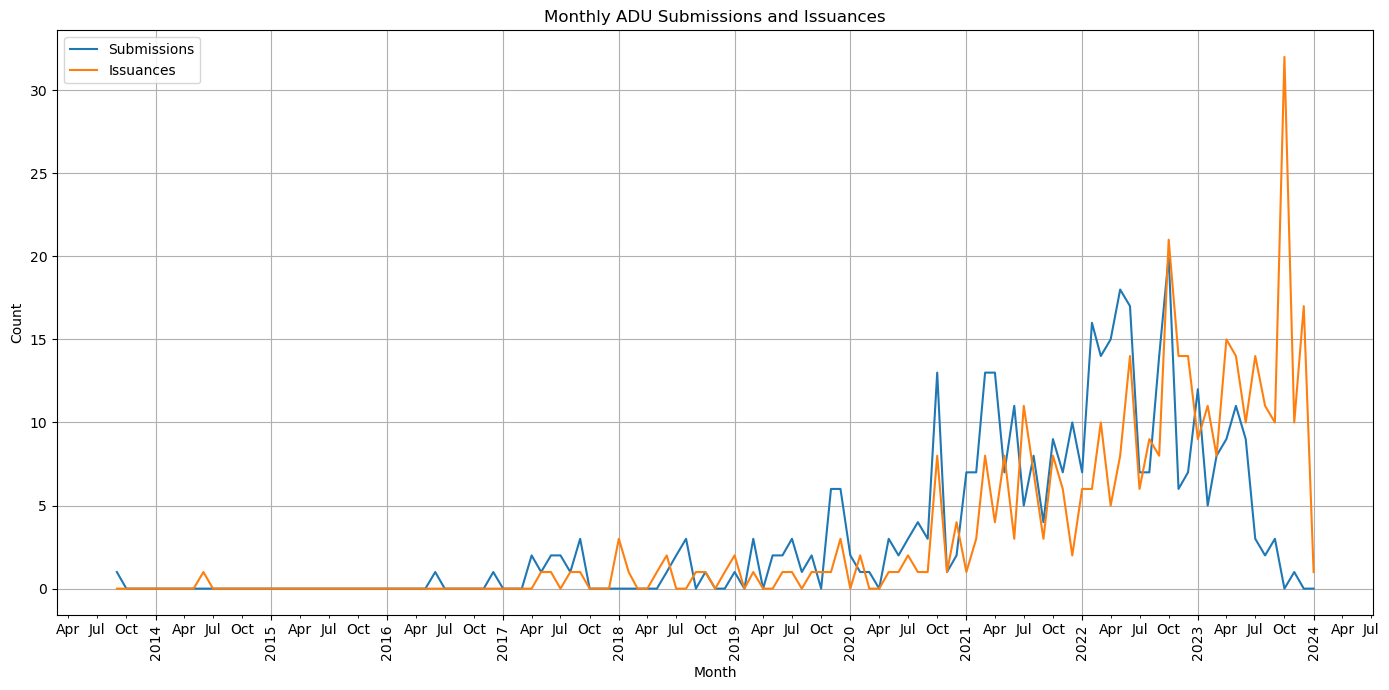

In [54]:
plt.figure(figsize=(14, 7))

# Convert index to datetime for better control over plotting
monthly_submissions.index = pd.to_datetime(monthly_submissions.index.astype(str))
monthly_issuances.index = pd.to_datetime(monthly_issuances.index.astype(str))

plt.plot(monthly_submissions.index, monthly_submissions.values, label='Submissions')
plt.plot(monthly_issuances.index, monthly_issuances.values, label='Issuances')

plt.title('Monthly ADU Submissions and Issuances')
plt.xlabel('Month')
plt.ylabel('Count')

# Set major and minor ticks
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(mdates.YearLocator())   # Set major ticks to show at the start of each year
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=(4, 7, 10)))  # Set minor ticks for April, July, October

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format major ticks to show only the year
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))  # Format minor ticks to show abbreviated month

plt.xticks(rotation=90)  # Rotate dates for better visibility
plt.legend()
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [58]:
total_issuances = monthly_issuances.sum()
average_submissions = monthly_submissions.mean()
average_issuances = monthly_issuances.mean()

print(f"Total Issuances: {total_issuances}")
print(f"Average Monthly Submissions: {average_submissions:.2f}")
print(f"Average Monthly Issuances: {average_issuances:.2f}")


Total Issuances: 394
Average Monthly Submissions: 3.15
Average Monthly Issuances: 3.15


In [ ]:

adu_cleaned['Issued Year'] = adu_cleaned['Date Issued'].dt.year




In [61]:
# Group by 'Issued Year' and count issuances
annual_issuances = adu_cleaned.groupby('Issued Year').size()

# Print annual totals
print("Annual Issuances:")
print(annual_issuances)

# Calculate average, max, and min
average_annual_issuances = annual_issuances.mean()
max_annual_issuances = annual_issuances.max()
min_annual_issuances = annual_issuances.min()

print(f"Average Annual Issuances: {average_annual_issuances:.2f}")
print(f"Maximum Annual Issuances: {max_annual_issuances}")
print(f"Minimum Annual Issuances: {min_annual_issuances}")


Annual Issuances:
Issued Year
2014      1
2017      4
2018     10
2019     11
2020     21
2021     64
2022    121
2023    161
2024      1
dtype: int64
Average Annual Issuances: 43.78
Maximum Annual Issuances: 161
Minimum Annual Issuances: 1


In [62]:
# Calculate Year-over-Year growth in percentages
yoy_growth = annual_issuances.pct_change() * 100

print("Year-over-Year Growth in Issuances:")
print(yoy_growth.dropna())  # Drop NA to avoid displaying empty values for the first year


Year-over-Year Growth in Issuances:
Issued Year
2017    300.000000
2018    150.000000
2019     10.000000
2020     90.909091
2021    204.761905
2022     89.062500
2023     33.057851
2024    -99.378882
dtype: float64


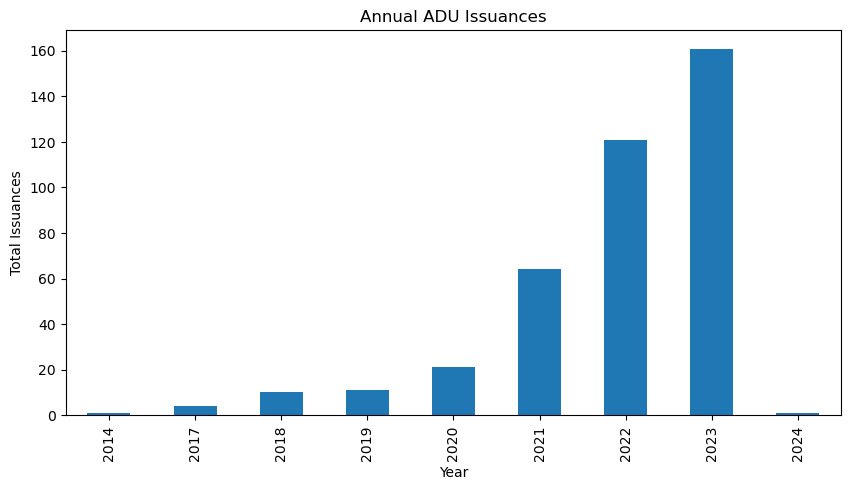

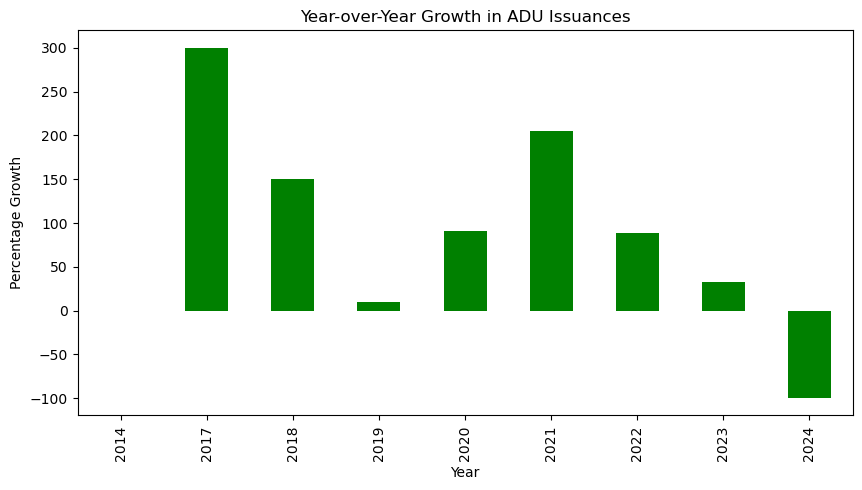

In [63]:
# Plot total annual issuances
plt.figure(figsize=(10, 5))
annual_issuances.plot(kind='bar')
plt.title('Annual ADU Issuances')
plt.xlabel('Year')
plt.ylabel('Total Issuances')
plt.show()

# Plot Year-over-Year Growth
plt.figure(figsize=(10, 5))
yoy_growth.plot(kind='bar', color='green')
plt.title('Year-over-Year Growth in ADU Issuances')
plt.xlabel('Year')
plt.ylabel('Percentage Growth')
plt.show()

In [64]:
parcel_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\community\assessorparcels_20210708_closedroll.gpkg"
parcels = gpd.read_file(parcel_path, dtype={'APN': str})


In [ ]:
merged_aduparcels = filtered_adus.merge(parcels, on='APN', how='inner')
merged_aduparcels


In [70]:
unmatched_adus = filtered_adus[~filtered_adus['APN'].isin(parcels['APN'])]
unmatched_adus.count()


Case #                  9
Associated EXE          0
Associated ZCI          1
APN                     9
Owner Name              9
Owner Address           9
Owner City State Zip    9
Community Plan Area     3
Site Address            9
Date Submitted          9
Date Issued             5
Date Finaled            0
Status                  9
Project Description     9
Zoning                  3
dtype: int64

In [72]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_aduparcels)

# Save the GeoDataFrame to a file
gdf.to_file('C:/Users/bsf31/Documents/post-meds/data/signal/community/adu_parcel.gpkg', layer='merged_layer', driver='GPKG')


In [73]:
# Count unique values in the 'landuse' column
landuse_counts = gdf['LandUse'].value_counts()

print(landuse_counts)


LandUse
SINGLE FAMILY RESIDENCE              472
VACANT                                53
RANCHO ESTATES (RURAL HOME SITES)     45
RESIDENTIAL INCOME, 2-4 UNITS         12
PASTURE OF GRAZING, DRY                7
APARTMENTS, 5 OR MORE UNITS            7
ORCHARDS, IRRIGATED                    2
FIELD CROPS-IRRIGATED                  2
COMMERCIAL (MISC)                      2
VINEYARDS                              1
RETAIL STORES, SINGLE STORY            1
HIGHWAYS AND STREETS                   1
Name: count, dtype: int64


In [74]:
landuse_counts.sum()


605

In [75]:
landuse_counts

LandUse
SINGLE FAMILY RESIDENCE              472
VACANT                                53
RANCHO ESTATES (RURAL HOME SITES)     45
RESIDENTIAL INCOME, 2-4 UNITS         12
PASTURE OF GRAZING, DRY                7
APARTMENTS, 5 OR MORE UNITS            7
ORCHARDS, IRRIGATED                    2
FIELD CROPS-IRRIGATED                  2
COMMERCIAL (MISC)                      2
VINEYARDS                              1
RETAIL STORES, SINGLE STORY            1
HIGHWAYS AND STREETS                   1
Name: count, dtype: int64

In [76]:
# Map categories to the land use types

categories = { 'Critical Infrastructure': ['UTILITY,WATER COMPANY', 'WATER RIGHTS,PUMPS', 
                                           'PUBLIC BLDGS,FIREHOUSES,MUSEUMS,POST OFFICES,ETC', 'SCHOOLS', 
                                           'HOSPITALS', 'PIPELINES,CANALS', 
                                           'HIGHWAYS AND STREETS', 'COLLEGES', 
                                           'CHURCHES, RECTORY', 'DAY CARE', 'REST HOMES'], 
              'High-Risk Infrastructure': ['PETROLEUM AND GAS', 'LIGHT MANUFACTURING', 'HEAVY INDUSTRY', 
                                           'WAREHOUSING', 'INDUSTRIAL, MISC', 
                                           'PACKING PLANTS', 'LUMBER YARDS, MILLS', 
                                           'OTHER FOOD PROCESSING, BAKERIES', 'INDUSTRIAL CONDOS,PUDS'], 
              'Residential': ['SINGLE FAMILY RESIDENCE', 'CONDOS,COMMUNITY APT PROJS', 
                              'MOBILE HOMES', 'RESIDENTIAL INCOME, 2-4 UNITS', 
                              'RANCHO ESTATES (RURAL HOME SITES)', 
                              'APARTMENTS, 5 OR MORE UNITS', 
                              'MIXED USE-COMMERCIAL/RESIDENTIAL', 'MOBILE HOME PARKS'], 
              'Commercial': ['RETAIL STORES, SINGLE STORY', 'COMMERCIAL (MISC)', 'COMMERCIAL AND OFFICE CONDOS,PUDS', 
                             'OFFICE BUILDINGS, SINGLE STORY', 'OFFICE BUILDINGS, MULTI-STORY', 
                             'AUTO SALES, REPAIR, STORAGE, CAR WASH, ETC', 'RESTAURANTS,BARS', 'HOTELS', 
                             'SERVICE STATIONS', 'STORE AND OFFICE COMBINATION', 'SHOPPING CENTERS (NEIGHBORHOOD)', 
                             'BANKS, S&LS', 'SUPERMARKETS', 'PROFESSIONAL BUILDINGS', 'WHOLESALE LAUNDRY', 'SHOPPING CENTERS (REGIONAL)'], 
              'Agricultural': ['PASTURE OF GRAZING, DRY', 'ORCHARDS, IRRIGATED', 'IRRIGATED FARMS, MISC', 
                               'FIELD CROPS-IRRIGATED', 'FIELD CROPS, DRY', 'VINES AND BUSH FRUIT-IRRIGATED', 
                               'DRY FARMS (MISC)', 'PASTURE-IRRIGATED', 'NURSERIES,GREENHOUSES', 'ORCHARDS', 'GOLF COURSES', 
                               'VINEYARDS', 'TREE FARMS', 'TRUCK CROPS-IRRIGATED', 'POULTRY'],
            'Miscellaneous': ['VACANT', 'RECREATIONAL OPEN (MISC)', 'MISCELLANEOUS', 'BEACHES, SAND DUNES', 
                              'PARKS', 'INSTITUTIONAL (MISC)', 'RIVERS AND LAKES', 'FLOWERS', 'OPEN STORAGE, BULK PLANT', 
                              'CLUBS, LODGE HALLS', 'MORTUARIES,CEMETERIES,MAUSOLEUMS', 'CAMPS, CABINS', 
                              'HORSES', 'RACE TRACKS, RIDING STABLES', 
                              'RECREATION', 'DANCE HALLS', 'BED AND BREAKFAST', 
                              'AUDITORIUMS, STADIUMS', 'BOWLING ALLEYS', 
                              'DRIVE-IN THEATRES', 'PARKING LOTS', 'RIGHTS OF WAY,SEWER,LAND FILLS,ETC', 'WASTE'] }

In [77]:
# Assign categories to each land use type
def assign_category(landuse):
    for category, types in categories.items():
        if landuse in types:
            return category
    return 'Null'

In [78]:
gdf['Category'] = gdf['LandUse'].apply(assign_category)

In [79]:
adu_category = gdf[['Category', 'geometry']]

In [80]:
adu_category

,Category,geometry
0,Residential,"MULTIPOLYGON (((5938567.349 2076082.065, 59385..."
1,Residential,"MULTIPOLYGON (((5848412.771 2163374.204, 58483..."
2,Residential,"MULTIPOLYGON (((6025496.314 1985330.844, 60254..."
3,Residential,"MULTIPOLYGON (((6064984.890 1984932.233, 60648..."
4,Residential,"MULTIPOLYGON (((6071072.053 1982789.518, 60710..."
...,...,...
600,Residential,"MULTIPOLYGON (((6044680.294 1988047.354, 60446..."
601,Residential,"MULTIPOLYGON (((6045969.879 1989890.529, 60459..."
602,Residential,"MULTIPOLYGON (((6064946.631 1981636.930, 60648..."
603,Residential,"MULTIPOLYGON (((6065623.167 1986567.941, 60656..."


In [81]:

output_dir = os.path.join(r"C:\Users\bsf31\Documents\post-meds\data\signal\community")
os.makedirs(output_dir, exist_ok=True)

# Specify the output file name and format
output_file = os.path.join(output_dir, "adu_catagories.gpkg")

# Save the GeoDataFrame to the specified file
adu_category.to_file(output_file, driver="GPKG")

In [82]:
# Convert the Series to a DataFrame for plotting
df = landuse_counts.reset_index()
df.columns = ['LandUse', 'Count']


In [83]:
df

,LandUse,Count
0,SINGLE FAMILY RESIDENCE,472
1,VACANT,53
2,RANCHO ESTATES (RURAL HOME SITES),45
3,"RESIDENTIAL INCOME, 2-4 UNITS",12
4,"PASTURE OF GRAZING, DRY",7
5,"APARTMENTS, 5 OR MORE UNITS",7
6,"ORCHARDS, IRRIGATED",2
7,FIELD CROPS-IRRIGATED,2
8,COMMERCIAL (MISC),2
9,VINEYARDS,1


In [84]:
df['Category'] = df['LandUse'].apply(assign_category)
df

,LandUse,Count,Category
0,SINGLE FAMILY RESIDENCE,472,Residential
1,VACANT,53,Miscellaneous
2,RANCHO ESTATES (RURAL HOME SITES),45,Residential
3,"RESIDENTIAL INCOME, 2-4 UNITS",12,Residential
4,"PASTURE OF GRAZING, DRY",7,Agricultural
5,"APARTMENTS, 5 OR MORE UNITS",7,Residential
6,"ORCHARDS, IRRIGATED",2,Agricultural
7,FIELD CROPS-IRRIGATED,2,Agricultural
8,COMMERCIAL (MISC),2,Commercial
9,VINEYARDS,1,Agricultural


In [85]:
category_counts = df.groupby('Category')['Count'].sum()

category_counts

Category
Agricultural                12
Commercial                   3
Critical Infrastructure      1
Miscellaneous               53
Residential                536
Name: Count, dtype: int64

In [86]:
# Convert the Series to a DataFrame
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['Category', 'Count']


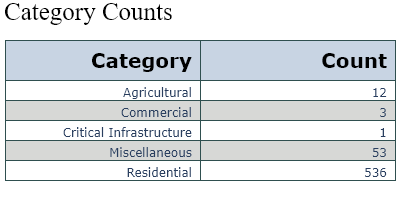

In [87]:
fig = df2img.plot_dataframe(
    category_counts_df,
    print_index = False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",
        font_color="black",
        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(400, 200),
)

df2img.save_dataframe(fig=fig, filename="category_counts.png")

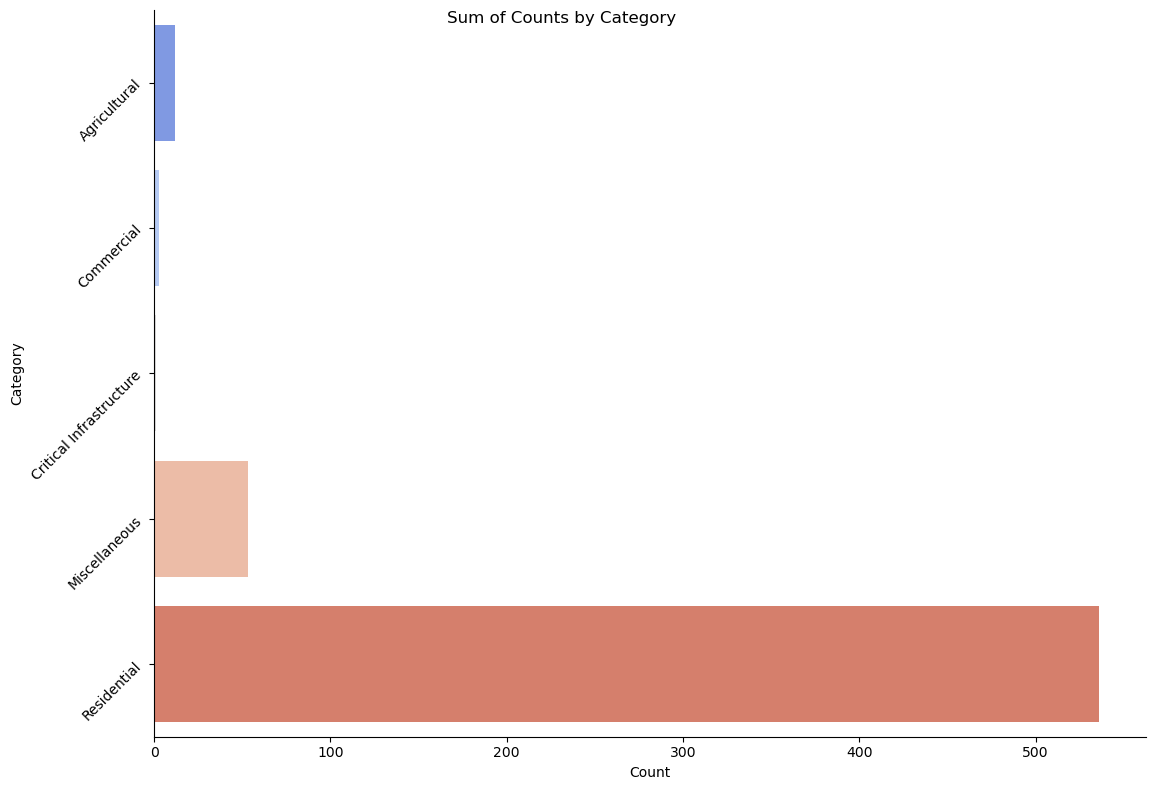

In [88]:
# Convert the Series to a DataFrame
category_data = category_counts.reset_index()
category_data.columns = ['Category', 'Count']

# Create a bar plot using seaborn.catplot
g = sns.catplot(x='Count', y='Category', kind='bar', data=category_data, palette='coolwarm', hue = 'Category', legend= False, height=8, aspect=1.5)
g.set_yticklabels(rotation=45, horizontalalignment='right')  # Rotate labels to avoid overlapping
g.fig.suptitle('Sum of Counts by Category')  # Title for the plot

plt.show()


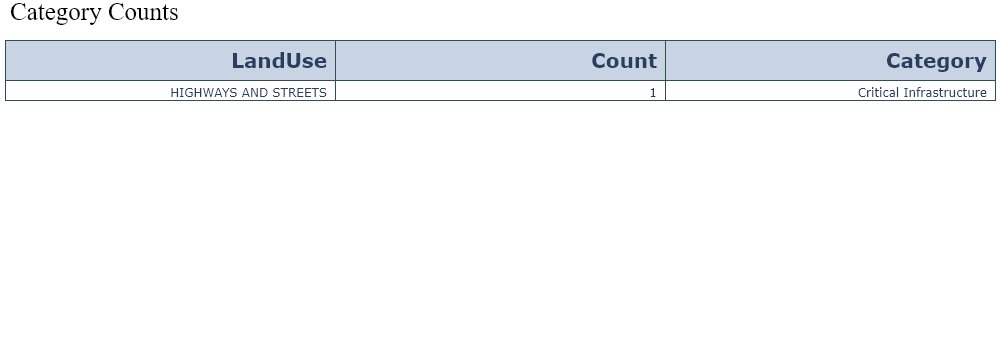

In [89]:


# Filter the DataFrame for only 'Critical Infrastructure' category
critical_infrastructure_df = df[df['Category'] == 'Critical Infrastructure']

# Sort the data by count for better visualization
critical_infrastructure_df = critical_infrastructure_df.sort_values('Count', ascending=False)
critical_infrastructure_df

fig = df2img.plot_dataframe(
    critical_infrastructure_df,
    print_index = False,
    title=dict(
        font_family="Times New Roman",
        font_color = 'black',
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",

        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1000,350),
)

df2img.save_dataframe(fig=fig, filename="critical_infrastructure.png")

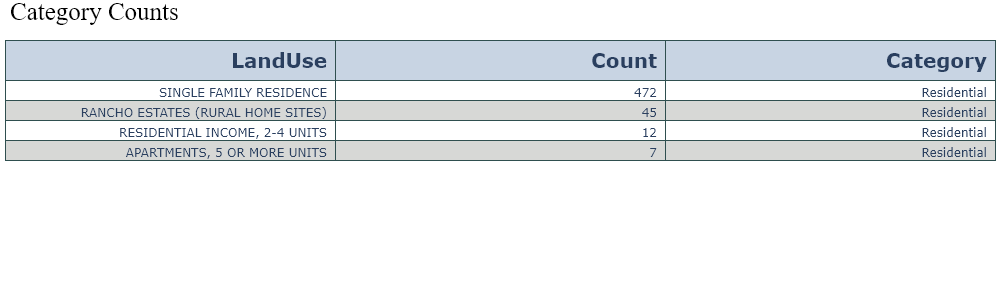

In [90]:
# Filter the DataFrame for only 'Critical Infrastructure' category
Residential_df = df[df['Category'] == 'Residential']

# Sort the data by count for better visualization
Residential_df = Residential_df.sort_values('Count', ascending=False)
Residential_df

# %%
fig = df2img.plot_dataframe(
    Residential_df,
    print_index = False,
    title=dict(
        font_family="Times New Roman",
        font_color = 'black',
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",

        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1000,300),
)

df2img.save_dataframe(fig=fig, filename="Residential.png")



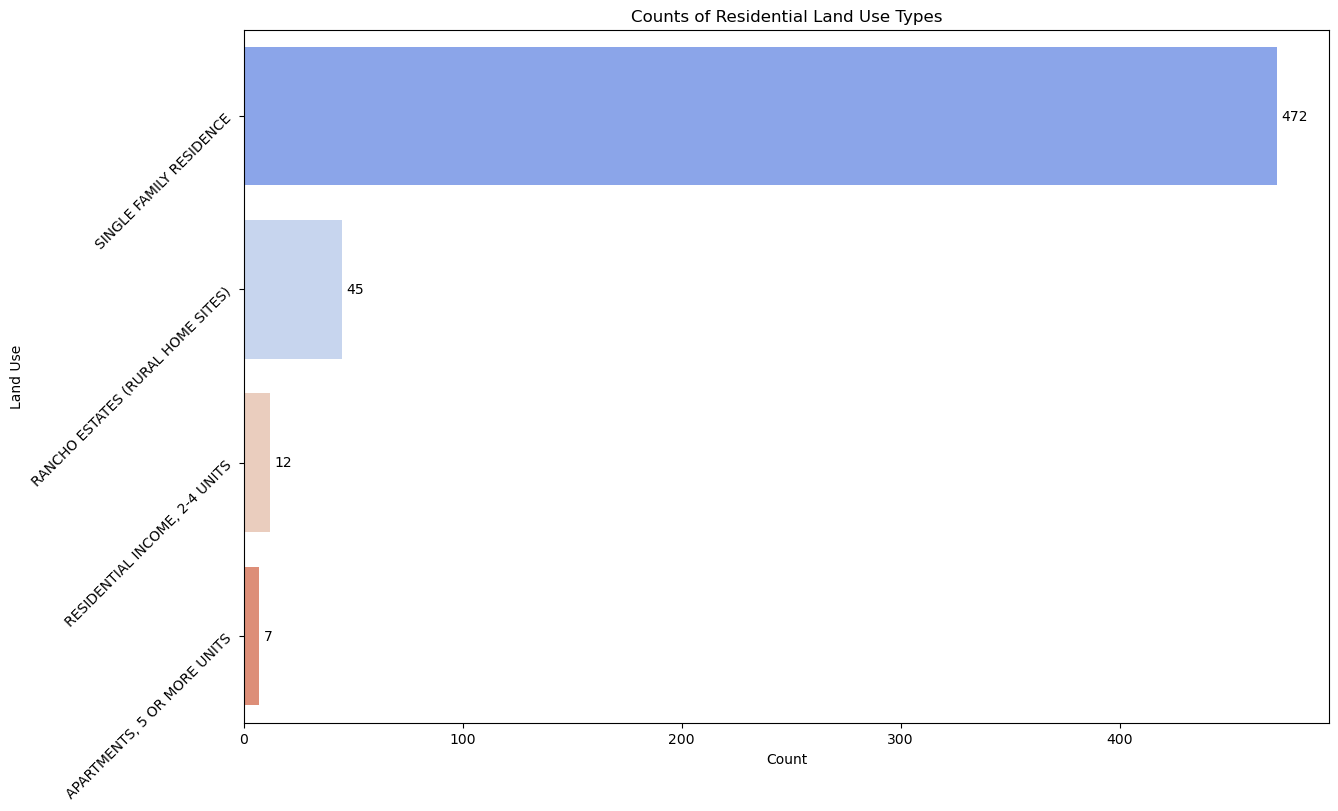

In [91]:

plt.figure(figsize=(14, 9))
ax = sns.barplot(x='Count', y='LandUse', data=Residential_df, palette='coolwarm', hue='LandUse', legend = False)
# Iterate over all containers and label each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=10)
plt.title('Counts of Residential Land Use Types')
plt.xlabel('Count')
plt.yticks(rotation=45)
plt.ylabel('Land Use')
plt.show()


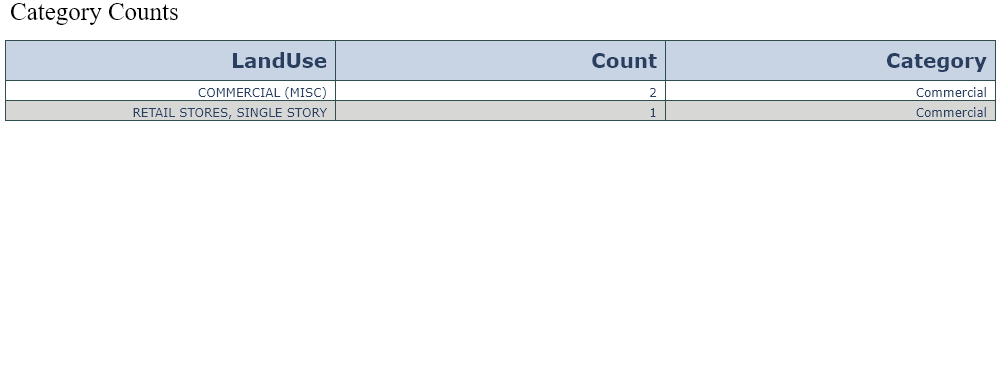

In [92]:
# Filter the DataFrame for only 'Critical Infrastructure' category
Commercial_df = df[df['Category'] == 'Commercial']

# Sort the data by count for better visualization
Commercial_df = Commercial_df.sort_values('Count', ascending=False)
Commercial_df

# %%
fig = df2img.plot_dataframe(
    Commercial_df,
    print_index = False,
    title=dict(
        font_family="Times New Roman",
        font_color = 'black',
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",

        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1000,375),
)

df2img.save_dataframe(fig=fig, filename="Commercial.png")

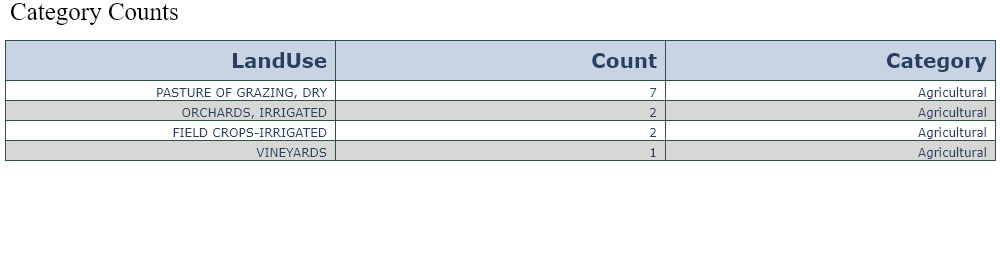

In [93]:
# Filter the DataFrame for only 'Critical Infrastructure' category
Agricultural_df = df[df['Category'] == 'Agricultural']

# Sort the data by count for better visualization
Agricultural_df = Agricultural_df.sort_values('Count', ascending=False)
Agricultural_df

# %%
fig = df2img.plot_dataframe(
    Agricultural_df,
    print_index = False,
    title=dict(
        font_family="Times New Roman",
        font_color = 'black',
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",

        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1000,275),
)

df2img.save_dataframe(fig=fig, filename="Agricultural.png")

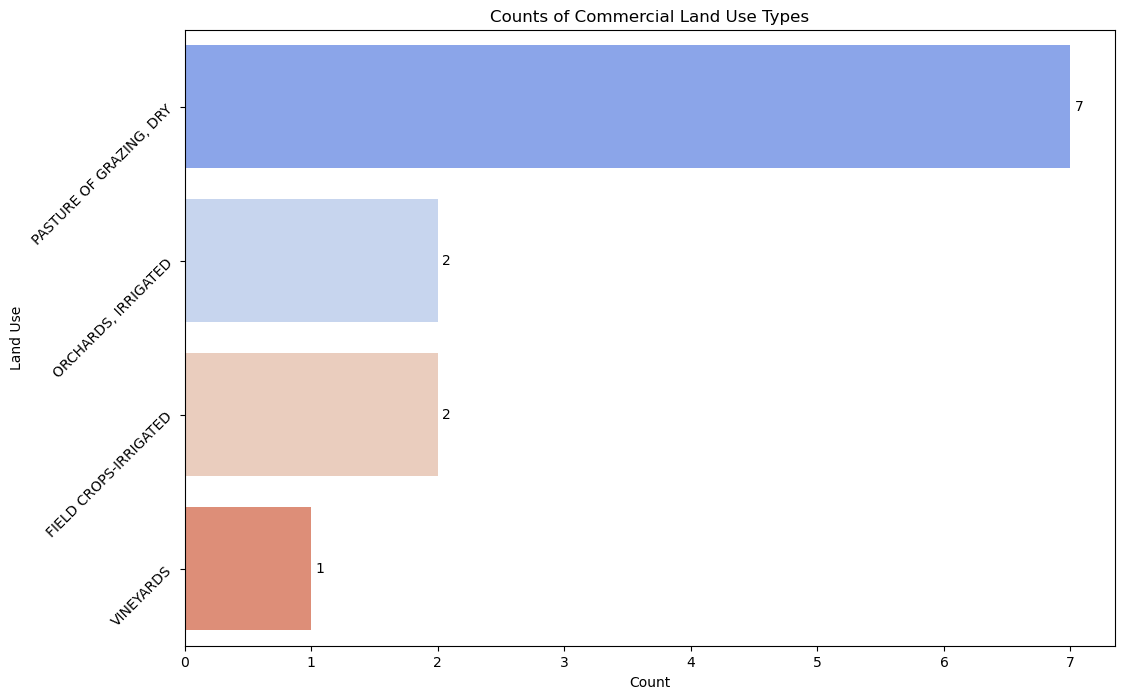

In [94]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Count', y='LandUse', data=Agricultural_df, palette='coolwarm', hue='LandUse', legend = False)
# Iterate over all containers and label each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=3, fontsize=10)
plt.title('Counts of Commercial Land Use Types')
plt.xlabel('Count')
plt.yticks(rotation=45)
plt.ylabel('Land Use')
plt.show()

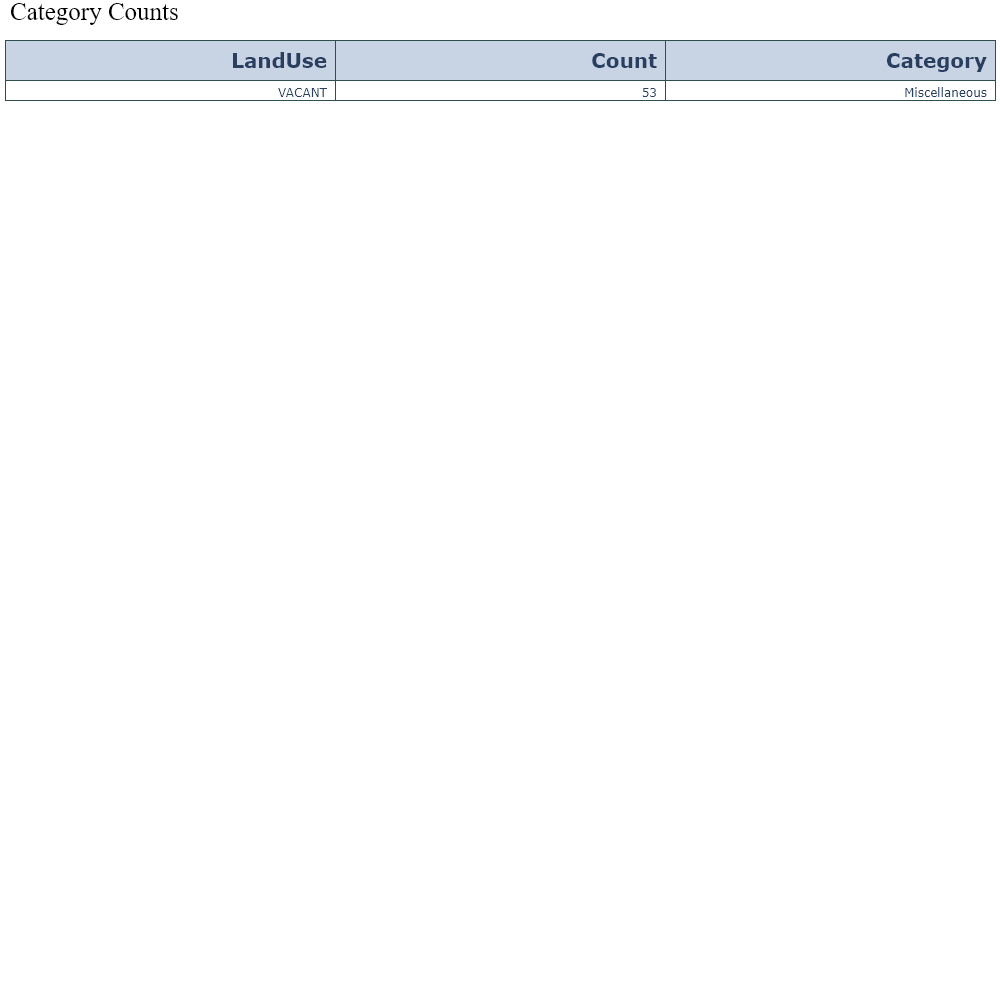

In [95]:
# Filter the DataFrame for only 'Critical Infrastructure' category
Miscellaneous_df = df[df['Category'] == 'Miscellaneous']

# Sort the data by count for better visualization
Miscellaneous_df = Miscellaneous_df.sort_values('Count', ascending=False)
Miscellaneous_df

# %%
fig = df2img.plot_dataframe(
    Miscellaneous_df,
    print_index = False,
    title=dict(
        font_family="Times New Roman",
        font_color = 'black',
        font_size=25,
        text="Category Counts",
    ),
    tbl_header=dict(
        align="right",

        font_size=20,
        line_color="darkslategray",
    ),
    tbl_cells=dict(
        align="right",
        line_color="darkslategray",
    ),
    row_fill_color=("#ffffff", "#d7d8d6"),
    fig_size=(1000,1000),
)

df2img.save_dataframe(fig=fig, filename="Miscellaneous.png")

In [96]:
adu_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\community\adu_catagories.gpkg"
adu_categories = gpd.read_file(adu_path)

In [97]:
Fhz_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\community\SBC_FHSZ_SRA_LRA.gpkg"
calfire_fhz = gpd.read_file(Fhz_path)

In [98]:
if adu_categories.crs != calfire_fhz.crs:
    calfire_fhz = calfire_fhz.to_crs(adu_categories.crs)

In [99]:
joined_data = gpd.sjoin(adu_categories, calfire_fhz, how="inner", predicate='within')

# Count the number of ADUs in each HAZ_CLASS
haz_class_counts = joined_data['HAZ_CLASS'].value_counts()
haz_class_counts

HAZ_CLASS
Very High    177
Moderate      72
High          58
Name: count, dtype: int64

In [104]:
city_counts  = merged_aduparcels['SCity'].value_counts()
city_counts

SCity
SANTA BARBARA    358
SANTA MARIA      109
GOLETA            31
SANTA YNEZ        23
CARPINTERIA       16
SUMMERLAND        10
LOMPOC             9
ORCUTT             9
BUELLTON           8
SOLVANG            7
MONTECITO          6
LOS ALAMOS         3
LOS OLIVOS         2
GAVIOTA            1
Name: count, dtype: int64

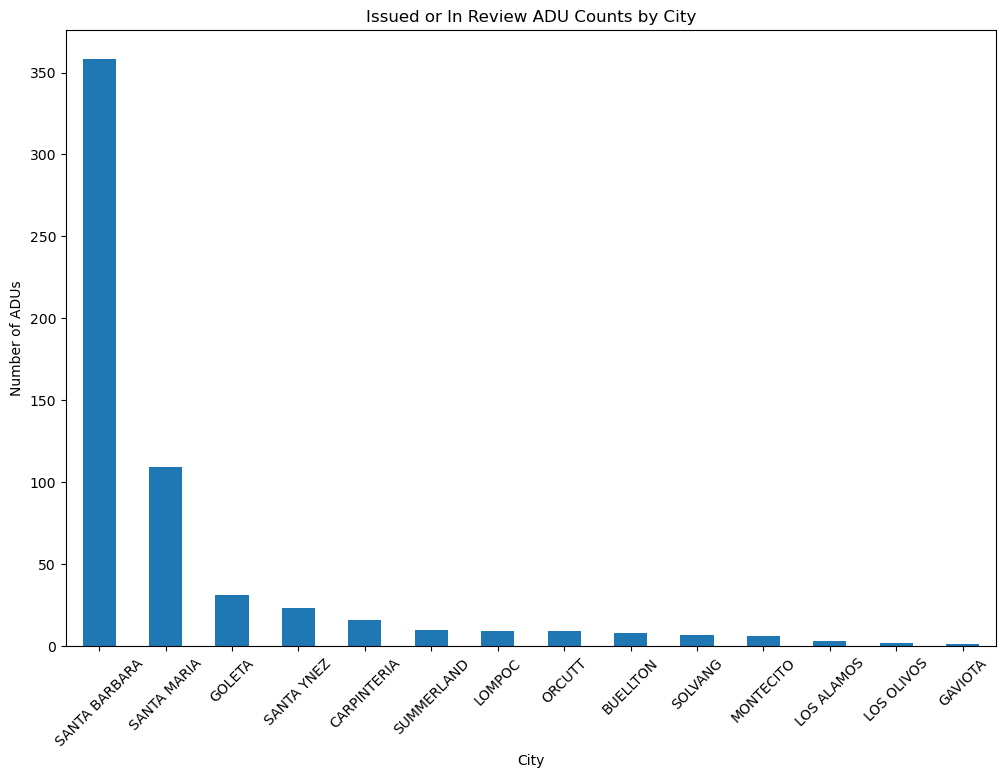

In [106]:

# Plotting the counts
plt.figure(figsize=(12, 8))
city_counts.plot(kind='bar')
plt.title('Issued or In Review ADU Counts by City')
plt.xlabel('City')
plt.ylabel('Number of ADUs')
plt.xticks(rotation=45)  # Rotate city names for better readability
plt.show()
